<a href="https://colab.research.google.com/github/DogaSahin/Twitter_Sentiment_Analysis/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Model & Preparing a proper train/test dataset

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
!kaggle datasets download -d kazanova/sentiment140
! unzip sentiment140.zip -d sample_data

Importing necesary libraries

In [ ]:
!pip install nltk


In [60]:
# for data preprocessing
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 

# data clearing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string

# Tensorlow Libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.layers import Embedding
from tensorflow.keras import layers
from tensorflow.keras import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import Activation
from keras.models import Model
from keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('wordnet')

Getting a labeled data

In [7]:
data = pd.read_csv("sample_data/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]
data.head()


,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [8]:
data.columns
print(len(data))
data.shape
data.info()
data.dtypes


1599999
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

Making a more meaningfull dataset

In [9]:
# Selecting the text and label coloumn Assigning 1 to Positive sentment 4

data=data[['text','label']]
data['label'][data['label']==4]=1

# Separating positive and negative tweets
positive_data = data[data['label'] == 1]
negative_data = data[data['label'] == 0]

# taking half of the dataset for try
positive_data = positive_data.iloc[:int(80000)]
negative_data = negative_data.iloc[:int(80000)]

# Combining positive and negative tweets & making all tweets lowercase so we can work better
data = pd.concat([positive_data, negative_data])
data['text']=data['text'].str.lower()

data['text'].head()
data.tail()

,text,label
79995,@itsaroy they hurt my feelings when they don't...,0
79996,excited that josh will be back in erie in an h...,0
79997,plans of going to the club have been dashed. n...,0
79998,i hate car washing,0
79999,"cannot actually keep my eyes open.., i feel li...",0


Cleaning and removing punctuations


In [10]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].head()

799999            i love health4uandpets u guys r the best 
800000    im meeting up with one of my besties tonight c...
800001    darealsunisakim thanks for the twitter add sun...
800002    being sick can be really cheap when it hurts t...
800003       lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

Removing email & URL's


In [11]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

data['text']= data['text'].apply(lambda x: cleaning_email(x))

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].head()

799999            i love health4uandpets u guys r the best 
800000    im meeting up with one of my besties tonight c...
800001    darealsunisakim thanks for the twitter add sun...
800002    being sick can be really cheap when it hurts t...
800003       lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

Cleaning and removing Numeric numbers

In [12]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].head()

799999             i love healthuandpets u guys r the best 
800000    im meeting up with one of my besties tonight c...
800001    darealsunisakim thanks for the twitter add sun...
800002    being sick can be really cheap when it hurts t...
800003        lovesbrooklyn he has that effect on everyone 
Name: text, dtype: object

Cleaning stopwords from the dataset

In [13]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'me', 'so', 'our', 'during', "isn't", 'because', 'had', "shan't", 'just', 'his', 'himself', 'that', 'no', 'wouldn', 'myself', 'shouldn', 'we', 'is', 'not', 'wasn', 'from', "it's", 'being', 'off', 'any', 'in', 'where', 'other', 'or', "weren't", 'hasn', 'there', 'same', 'than', 'll', 'she', 'as', 'these', 'few', 'but', 'aren', 'they', "hasn't", 'my', 'why', "you've", 'until', 'its', 'to', 'd', 'didn', 'doesn', 'having', 'been', 'very', "don't", 'between', 'over', 'such', "won't", 'if', 'you', 'out', 'haven', "wasn't", "doesn't", 'mightn', 'further', 'down', 'only', 'which', 'him', 'when', 'most', 'yours', 'this', 'and', 't', "should've", "didn't", 'should', 'a', 'her', 'own', 'hadn', 'o', 'won', "haven't", 'ours', 'their', 'whom', 'was', 're', "she's", 'all', 'can', "that'll", 'theirs', "you're", 'both', 'weren', 'some', 'don', 'yourself', 'ain', "mightn't", 'nor', 'more', 'you

In [14]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                    love healthuandpets u guys r best
800000    im meeting one besties tonight cant wait girl ...
800001    darealsunisakim thanks twitter add sunisa got ...
800002    sick really cheap hurts much eat real food plu...
800003                        lovesbrooklyn effect everyone
Name: text, dtype: object

tokenization of tweet

In [15]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

Stemming

In [16]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

Applying Lemmatizer

In [17]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()


799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

Data splitting and model building

In [18]:
X=data.text
y=data.label

max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

print(sequences_matrix.shape)

X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

(160000, 500)


# TENSORFLOW

In [32]:
def tensorflow_based_model():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer) 
    return model

In [53]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below


Epoch 1/6
1260/1260 [==============================] - 524s 414ms/step - loss: 0.5577 - accuracy: 0.7053 - val_loss: 0.4943 - val_accuracy: 0.7613
Epoch 2/6
1260/1260 [==============================] - 528s 419ms/step - loss: 0.4862 - accuracy: 0.7644 - val_loss: 0.4875 - val_accuracy: 0.7636
Epoch 3/6
1260/1260 [==============================] - 520s 413ms/step - loss: 0.4771 - accuracy: 0.7688 - val_loss: 0.4894 - val_accuracy: 0.7656
Epoch 4/6
1260/1260 [==============================] - 521s 413ms/step - loss: 0.4695 - accuracy: 0.7751 - val_loss: 0.4879 - val_accuracy: 0.7662
Epoch 5/6
1260/1260 [==============================] - 523s 415ms/step - loss: 0.4624 - accuracy: 0.7803 - val_loss: 0.4850 - val_accuracy: 0.7661
Epoch 6/6
1260/1260 [==============================] - 521s 413ms/step - loss: 0.4573 - accuracy: 0.7825 - val_loss: 0.4867 - val_accuracy: 0.7671
Training finished !!
1500/1500 [==============================] - 99s 66ms/step - loss: 0.4913 - accuracy: 0.7615
Test



confusion matrix


[[18699  5339]
 [ 6107 17855]]




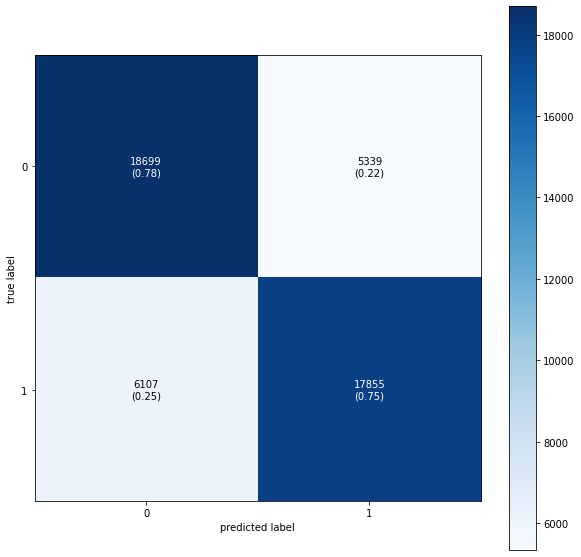

In [56]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

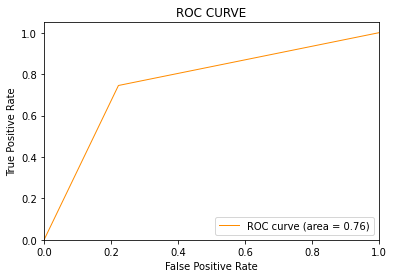

In [61]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()